# PDAC EDEG Analysis
This analysis uses Cluster 2 from the PDAC dataset to perform EDEG analysis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib_venn import venn2
import os
from scipy.stats import wilcoxon
from gseapy.plot import barplot, dotplot

In [2]:
leiden_res = "leiden_0_4_8"
cluster_num = "2"
gene_type = "MAST"

### Load all the DE 

In [4]:
## venn diagram

df_exon_DE = pd.read_csv("../../../02_model/02_exon/Go_output/N3_T10_T8_T20/Feature_"+leiden_res+"_cluster_"+cluster_num+".csv")
# df_exon_DE = pd.read_csv("../../../02_model/02_exon/Go_output/N3_T10_T8_T20/Feature_"+leiden_res+"_cluster_"+cluster_num+"_add_gene_stats.csv")
df_scanpy_DE = pd.read_csv("../../../02_model/00_scanpy/Go_output/N3_T10_T8_T20/Gene_"+leiden_res+"_cluster_"+cluster_num+"_MAST_v2_GeneRemap.csv")

df_exon_DE_sub = df_exon_DE[(df_exon_DE[gene_type+"_weighted_stouffer_pval_adj_bonf"] < 0.05) & (abs(df_exon_DE[gene_type+"_weighted_abs_avg_log2FC"]) > 1)].copy()
df_scanpy_DE_sub = df_scanpy_DE[(df_scanpy_DE[gene_type+"_pvals_adj"]<0.05) & (abs(df_scanpy_DE[gene_type+"_logfoldchanges"]) >1)].copy()

print("Number of DE in exon:", len(set(df_exon_DE_sub["Cancer_gene_names"])))
print("Number of DE in scanpy:", len(set(df_scanpy_DE_sub["Cancer_names_remap"])))

df_exon_DE_sub_unique = df_exon_DE_sub[~df_exon_DE_sub["Cancer_gene_names"].isin(df_scanpy_DE_sub["Cancer_names_remap"])]
print("Number of Unique DE in Exon:", len(set(df_exon_DE_sub_unique["Cancer_gene_names"])))

Number of DE in exon: 2339
Number of DE in scanpy: 1926
Number of Unique DE in Exon: 896


In [5]:
df_scanpy_DE_sub_unique = df_scanpy_DE_sub[~df_scanpy_DE_sub["Cancer_names_remap"].isin(df_exon_DE_sub["Cancer_gene_names"])]
print("Number of Unique DE in Scanpy:", len(set(df_scanpy_DE_sub_unique["Cancer_names_remap"])))

Number of Unique DE in Scanpy: 483


### Venn diagram

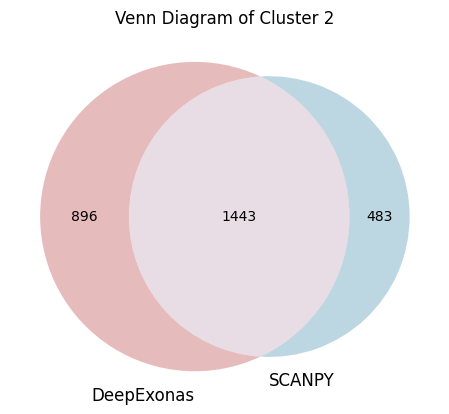

In [6]:
venn_diagram = venn2([set(df_exon_DE_sub["Cancer_gene_names"]), set(df_scanpy_DE_sub["Cancer_names_remap"])], ('DeepExonas', 'SCANPY'), set_colors=('#C25759', '#599CB4'))

plt.title("Venn Diagram of Cluster "+cluster_num)
plt.show()
plt.close()

### GO enrichment analysis

#### Deepexonas GO

In [7]:
go_exon = pd.read_csv("DE_exon.txt", sep="\t")
go_exon["Adjusted P-value"] = go_exon["q-value FDR B&H"]
go_exon["Term"] = go_exon["Name"]
go_exon["Gene_set"] = "DeepExonas"
go_exon_panc = go_exon[go_exon["Name"].str.contains("pancrea", case=False, na=False)].copy()

#### MAST gene GO

In [8]:
go_gene = pd.read_csv("DE_gene.txt", sep="\t")
go_gene["Adjusted P-value"] = go_gene["q-value FDR B&H"]
go_gene["Term"] = go_gene["Name"]
go_gene["Gene_set"] = "Gene"
go_gene_panc = go_gene[go_gene["Name"].str.contains("pancrea", case=False, na=False)].copy()

#### Unique gene GO - 896

In [9]:
go_unique_exon = pd.read_csv("DE_unique_exon.txt", sep="\t")
go_unique_exon["Adjusted P-value"] = go_unique_exon["q-value FDR B&H"]
go_unique_exon["Term"] = go_unique_exon["Name"]
go_unique_exon["Gene_set"] = go_unique_exon["Category"]

go_unique_exon_panc = go_unique_exon[go_unique_exon["Name"].str.contains("pancrea", case=False, na=False)].copy()

#### Unqiue gene in GO

In [12]:
go_unique_scanpy = pd.read_csv("DE_unique_scanpy.txt", sep="\t")
go_unique_scanpy["Adjusted P-value"] = go_unique_scanpy["q-value FDR B&H"]
go_unique_scanpy["Term"] = go_unique_scanpy["Name"]
go_unique_scanpy["Gene_set"] = go_unique_scanpy["Category"]
go_unique_scanpy_panc = go_unique_scanpy[go_unique_scanpy["Name"].str.contains("pancrea", case=False, na=False)].copy()
len(go_unique_scanpy_panc)

0

### Draw top GO terms

#### DeepExonas and gene side by side GO

In [13]:
from gseapy.plot import barplot, dotplot

In [ ]:
pd_merge = pd.merge(go_exon_panc, go_gene_panc, on=["ID"], how="outer").rename(columns={"q-value FDR B&H_x":"q-value FDR B&H_exon", "q-value FDR B&H_y":"q-value FDR B&H_gene"})
pd_merge["Category"] = pd_merge['Category_x'].fillna(pd_merge['Category_y'])
pd_merge["Name"] = pd_merge['Name_x'].fillna(pd_merge['Name_y'])
pd_merge["q-value FDR B&H_exon"] = pd_merge['q-value FDR B&H_exon'].fillna(0)
pd_merge["q-value FDR B&H_gene"] = pd_merge['q-value FDR B&H_gene'].fillna(0)
pd_merge = pd_merge[["Category", "ID", "Name", "q-value FDR B&H_exon", "q-value FDR B&H_gene"]]
pd_merge = pd_merge[pd_merge["Category"]!="GO: Biological Process"]
pd_merge_final = pd_merge[pd_merge["Name"] != "TROPICAL CALCIFIC PANCREATITIS"]
len(pd_merge_final)

In [15]:
pd_merge_final = pd.read_csv("figure8b_GO_table.csv")

/mnt/data/kailu/anaconda3/envs/dvaegpuEnv/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mnt/data/kailu/anaconda3/envs/dvaegpuEnv/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/mnt/data/kailu/anaconda3/envs/dvaegpuEnv/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tmp/ipykernel_1868659/3377385327.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='-log10(FDR_exon)', y='Name', data=pd_merge_final, color='red', label='Exon',


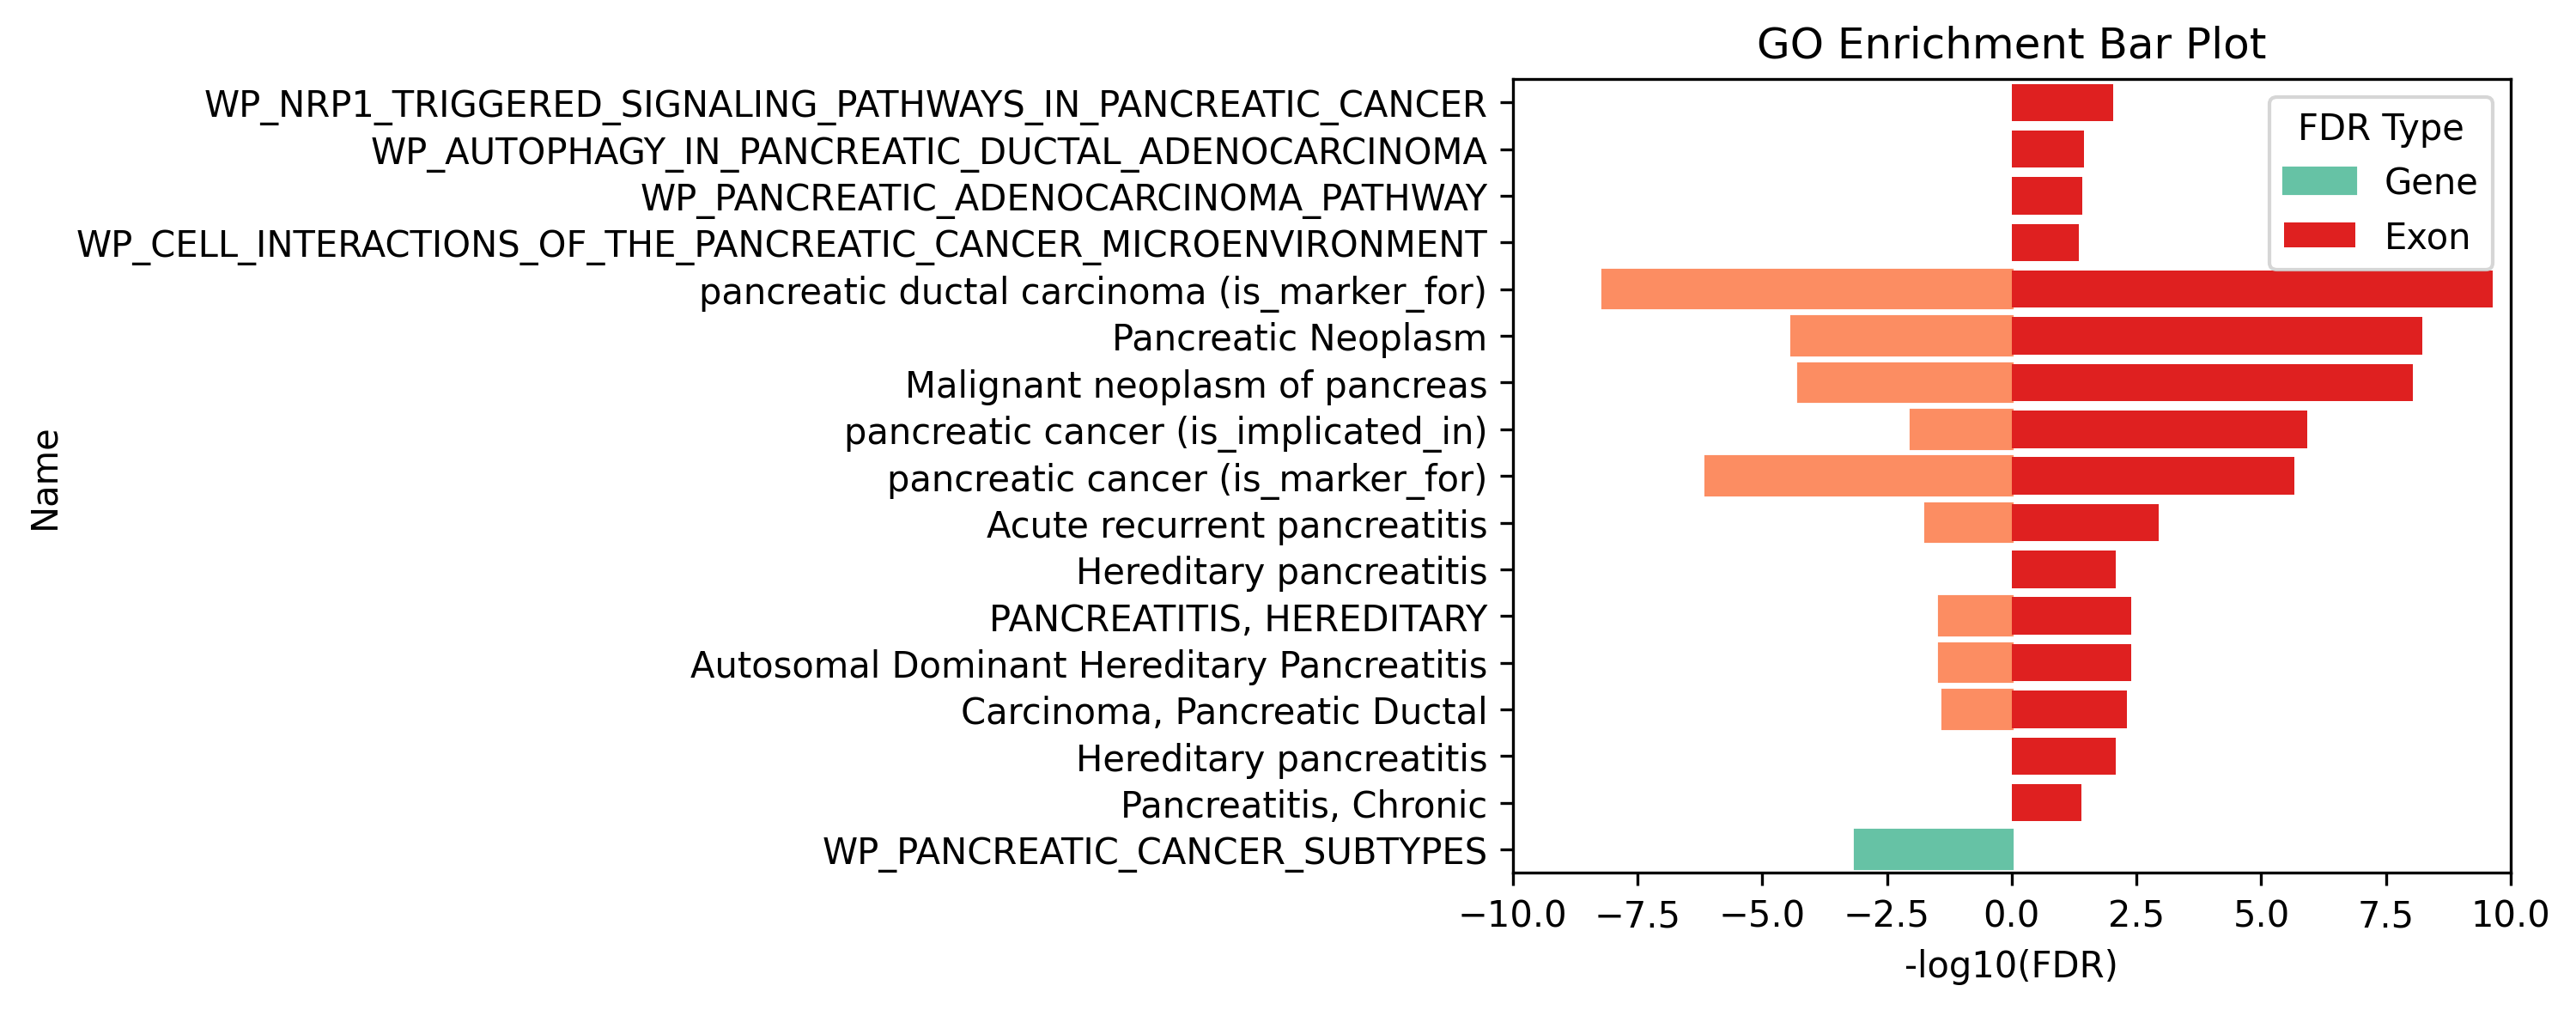

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load your dataframe (assuming it's named df)
# df = pd.read_csv("your_file.csv")  # Uncomment and adjust to load your data

# Prepare the data
pd_merge_final['-log10(FDR_gene)'] = np.log10(pd_merge_final['q-value FDR B&H_gene'])
pd_merge_final['-log10(FDR_exon)'] = -np.log10(pd_merge_final['q-value FDR B&H_exon'])

# Set color palette based on Category_x
categories = pd_merge_final['Category'].unique()
palette = sns.color_palette('Set2', len(categories))
category_colors = {category: palette[i] for i, category in enumerate(categories)}

# Plot
with plt.rc_context({"figure.figsize":(5,4), "figure.dpi": (300)}):
    # Bar plot for genes (left side)
    sns.barplot(x='-log10(FDR_gene)', y='Name', data=pd_merge_final, color='blue', label='Gene',
                order=pd_merge_final['Name'], orient='h')

    # Overlay bar plot for exons (right side)
    sns.barplot(x='-log10(FDR_exon)', y='Name', data=pd_merge_final, color='red', label='Exon',
                order=pd_merge_final['Name'], orient='h', ci=None)

    plt.xlim(-10, 10)
    # Add labels and title
    plt.xlabel('-log10(FDR)')
    plt.ylabel('Name')
    plt.title('GO Enrichment Bar Plot')

    # Color bars based on Category_x
    for index, category in enumerate(pd_merge_final['Category']):
        plt.gca().patches[index].set_color(category_colors[category])

    # Add legend
    plt.legend(title='FDR Type', loc='upper right')
    plt.show()
    plt.close()

#### Unique Exon Go - 896

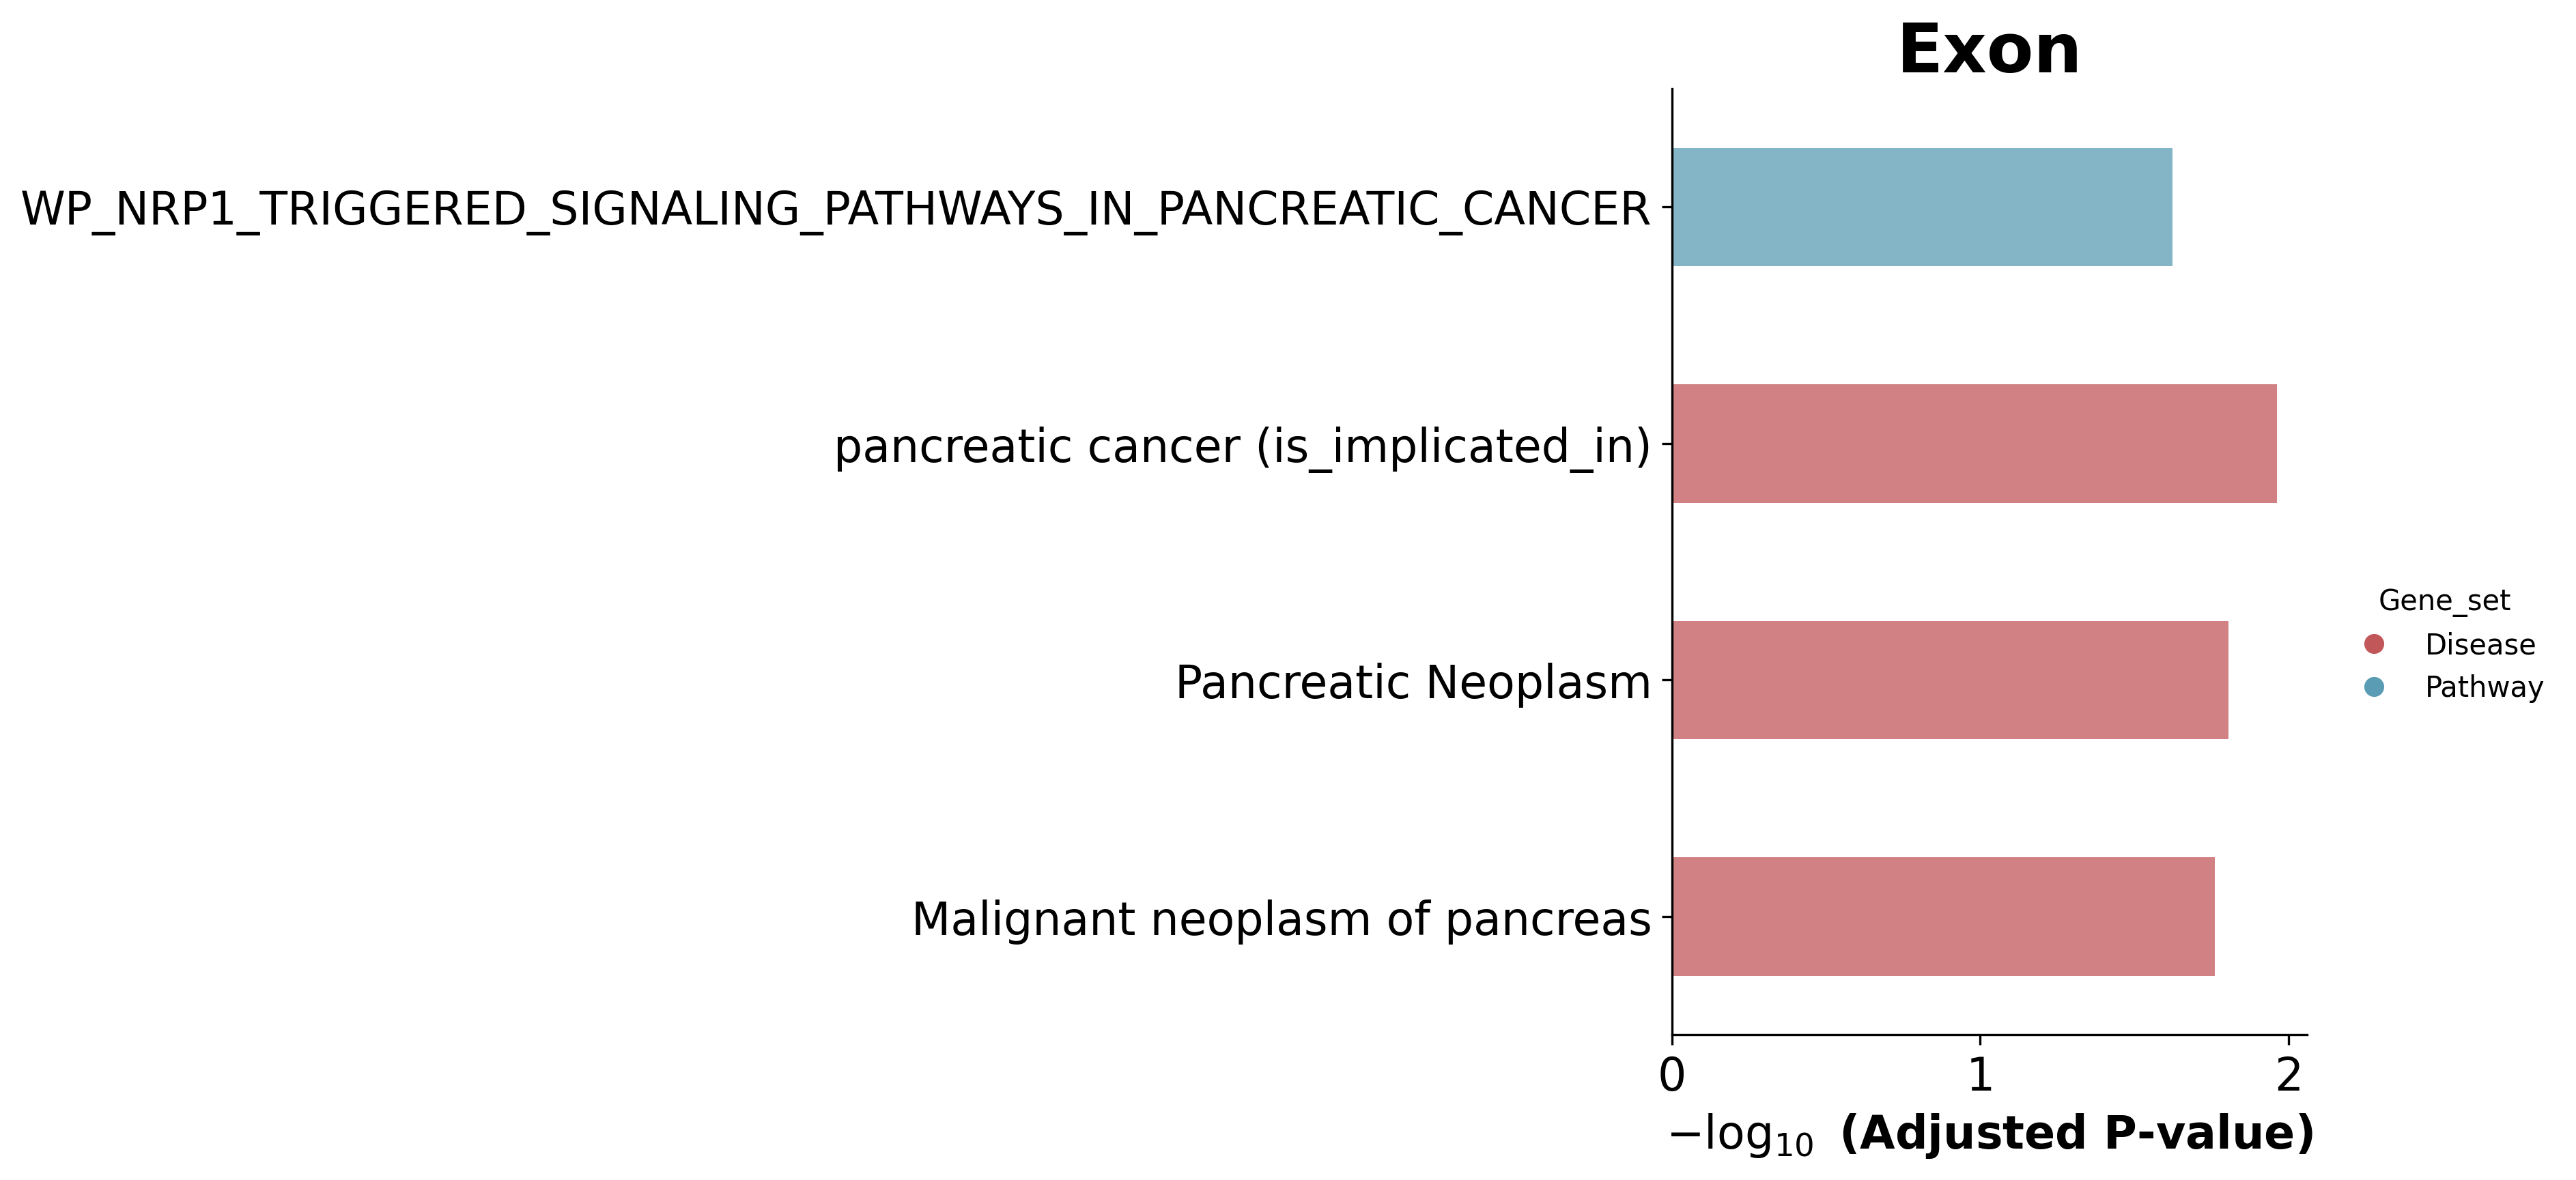

In [5]:
with plt.rc_context({"figure.figsize":(5,4), "figure.dpi": (300)}):
    barplot(go_unique_exon_panc,title='Exon',group='Gene_set',color = ['#C25759', '#599CB4'])
    # plt.show()
    plt.savefig("supp_unique_exon_896_go.pdf", format='pdf', bbox_inches="tight", dpi=300)